In [1]:
import pickle
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt


In [2]:

mpl.rcParams['figure.dpi'] = 1000

In [3]:
THRESHOLD_COUNT = 100
COLOR_SPACE = cv2.COLOR_BGR2YUV
THRESHOLD = [0, 0, 0]
MODEL = [[0, 0], [0, 0], [0, 0]]

In [4]:
skin_data = pd.read_csv("Skin_NonSkin.txt", names=["r", "g", "b", "skin"], sep="\t")

In [5]:
skin_data.head()

,r,g,b,skin
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [6]:
rgb_skin = skin_data.iloc[:,:-1].values

rgb_skin = rgb_skin.reshape((1, rgb_skin.shape[0], 3))
rgb_skin[:, :5]

array([[[ 74,  85, 123],
        [ 73,  84, 122],
        [ 72,  83, 121],
        [ 70,  81, 119],
        [ 70,  81, 119]]], dtype=int64)

In [7]:
hsv_skin = cv2.cvtColor(np.uint8(rgb_skin), COLOR_SPACE)
hsv_skin= hsv_skin.reshape((hsv_skin.shape[1], 3))
hsv_skin[:5]

array([[ 95, 118, 153],
       [ 94, 118, 153],
       [ 93, 118, 153],
       [ 91, 118, 153],
       [ 91, 118, 153]], dtype=uint8)

In [8]:
rgb2_skin = hsv_skin.reshape((1, hsv_skin.shape[0], 3))

rgb2_skin = cv2.cvtColor(np.uint8(rgb2_skin), cv2.COLOR_HSV2RGB)
rgb2_skin= rgb2_skin.reshape((rgb2_skin.shape[1], 3))
rgb2_skin[:5]

array([[ 82, 141, 153],
       [ 82, 143, 153],
       [ 82, 145, 153],
       [ 82, 150, 153],
       [ 82, 150, 153]], dtype=uint8)

In [9]:
skin_data["color_0"] = hsv_skin[:, 0]
skin_data["color_1"] = hsv_skin[:, 1]
skin_data["color_2"] = hsv_skin[:, 2]

skin_data.head()

,r,g,b,skin,color_0,color_1,color_2
0,74,85,123,1,95,118,153
1,73,84,122,1,94,118,153
2,72,83,121,1,93,118,153
3,70,81,119,1,91,118,153
4,70,81,119,1,91,118,153


In [10]:
means  = skin_data.loc[skin_data['skin'] == 1].mean()
hsv_skin_model_mean = [
    means["color_0"],
    means["color_1"],
    means["color_2"]
]

stds  = skin_data.loc[skin_data['skin'] == 1].std()
hsv_skin_model_std = [
    stds["color_0"],
    stds["color_1"],
    stds["color_2"]
]
hsv_skin_model_mean


[160.04351245600583, 105.27776794667611, 166.50958532413142]

In [11]:
skin_data["color_0_dist"] = np.abs((skin_data["color_0"] - hsv_skin_model_mean[0]) /\
                             hsv_skin_model_std[0])

skin_data["color_1_dist"] = np.abs((skin_data["color_1"] - hsv_skin_model_mean[1]) /\
                             hsv_skin_model_std[1])

skin_data["color_2_dist"] = np.abs((skin_data["color_2"] - hsv_skin_model_mean[2]) /\
                             hsv_skin_model_std[2])

skin_data.head()

,r,g,b,skin,color_0,color_1,color_2,color_0_dist,color_1_dist,color_2_dist
0,74,85,123,1,95,118,153,1.789107,1.616781,1.820239
1,73,84,122,1,94,118,153,1.816613,1.616781,1.820239
2,72,83,121,1,93,118,153,1.844119,1.616781,1.820239
3,70,81,119,1,91,118,153,1.899132,1.616781,1.820239
4,70,81,119,1,91,118,153,1.899132,1.616781,1.820239


In [12]:
from sklearn import svm

In [13]:
model = svm.SVC("linear")

,color_0_dist,color_1_dist,color_2_dist
0,1.789107,1.616781,1.820239
1,1.816613,1.616781,1.820239
2,1.844119,1.616781,1.820239
3,1.899132,1.616781,1.820239
4,1.899132,1.616781,1.820239


In [19]:
X = skin_data.loc[:,["color_0_dist", "color_1_dist", "color_2_dist"]]
X.head()

,color_0_dist,color_1_dist,color_2_dist
0,1.789107,1.616781,1.820239
1,1.816613,1.616781,1.820239
2,1.844119,1.616781,1.820239
3,1.899132,1.616781,1.820239
4,1.899132,1.616781,1.820239


In [18]:
Y = skin_data.loc[:,["skin"]]
Y.head()

,skin
0,1
1,1
2,1
3,1
4,1


In [20]:
model.fit(X,Y)

c:\users\wills\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC()

In [21]:
pickle.dump(model, open("SVM_MODEL", 'wb'))

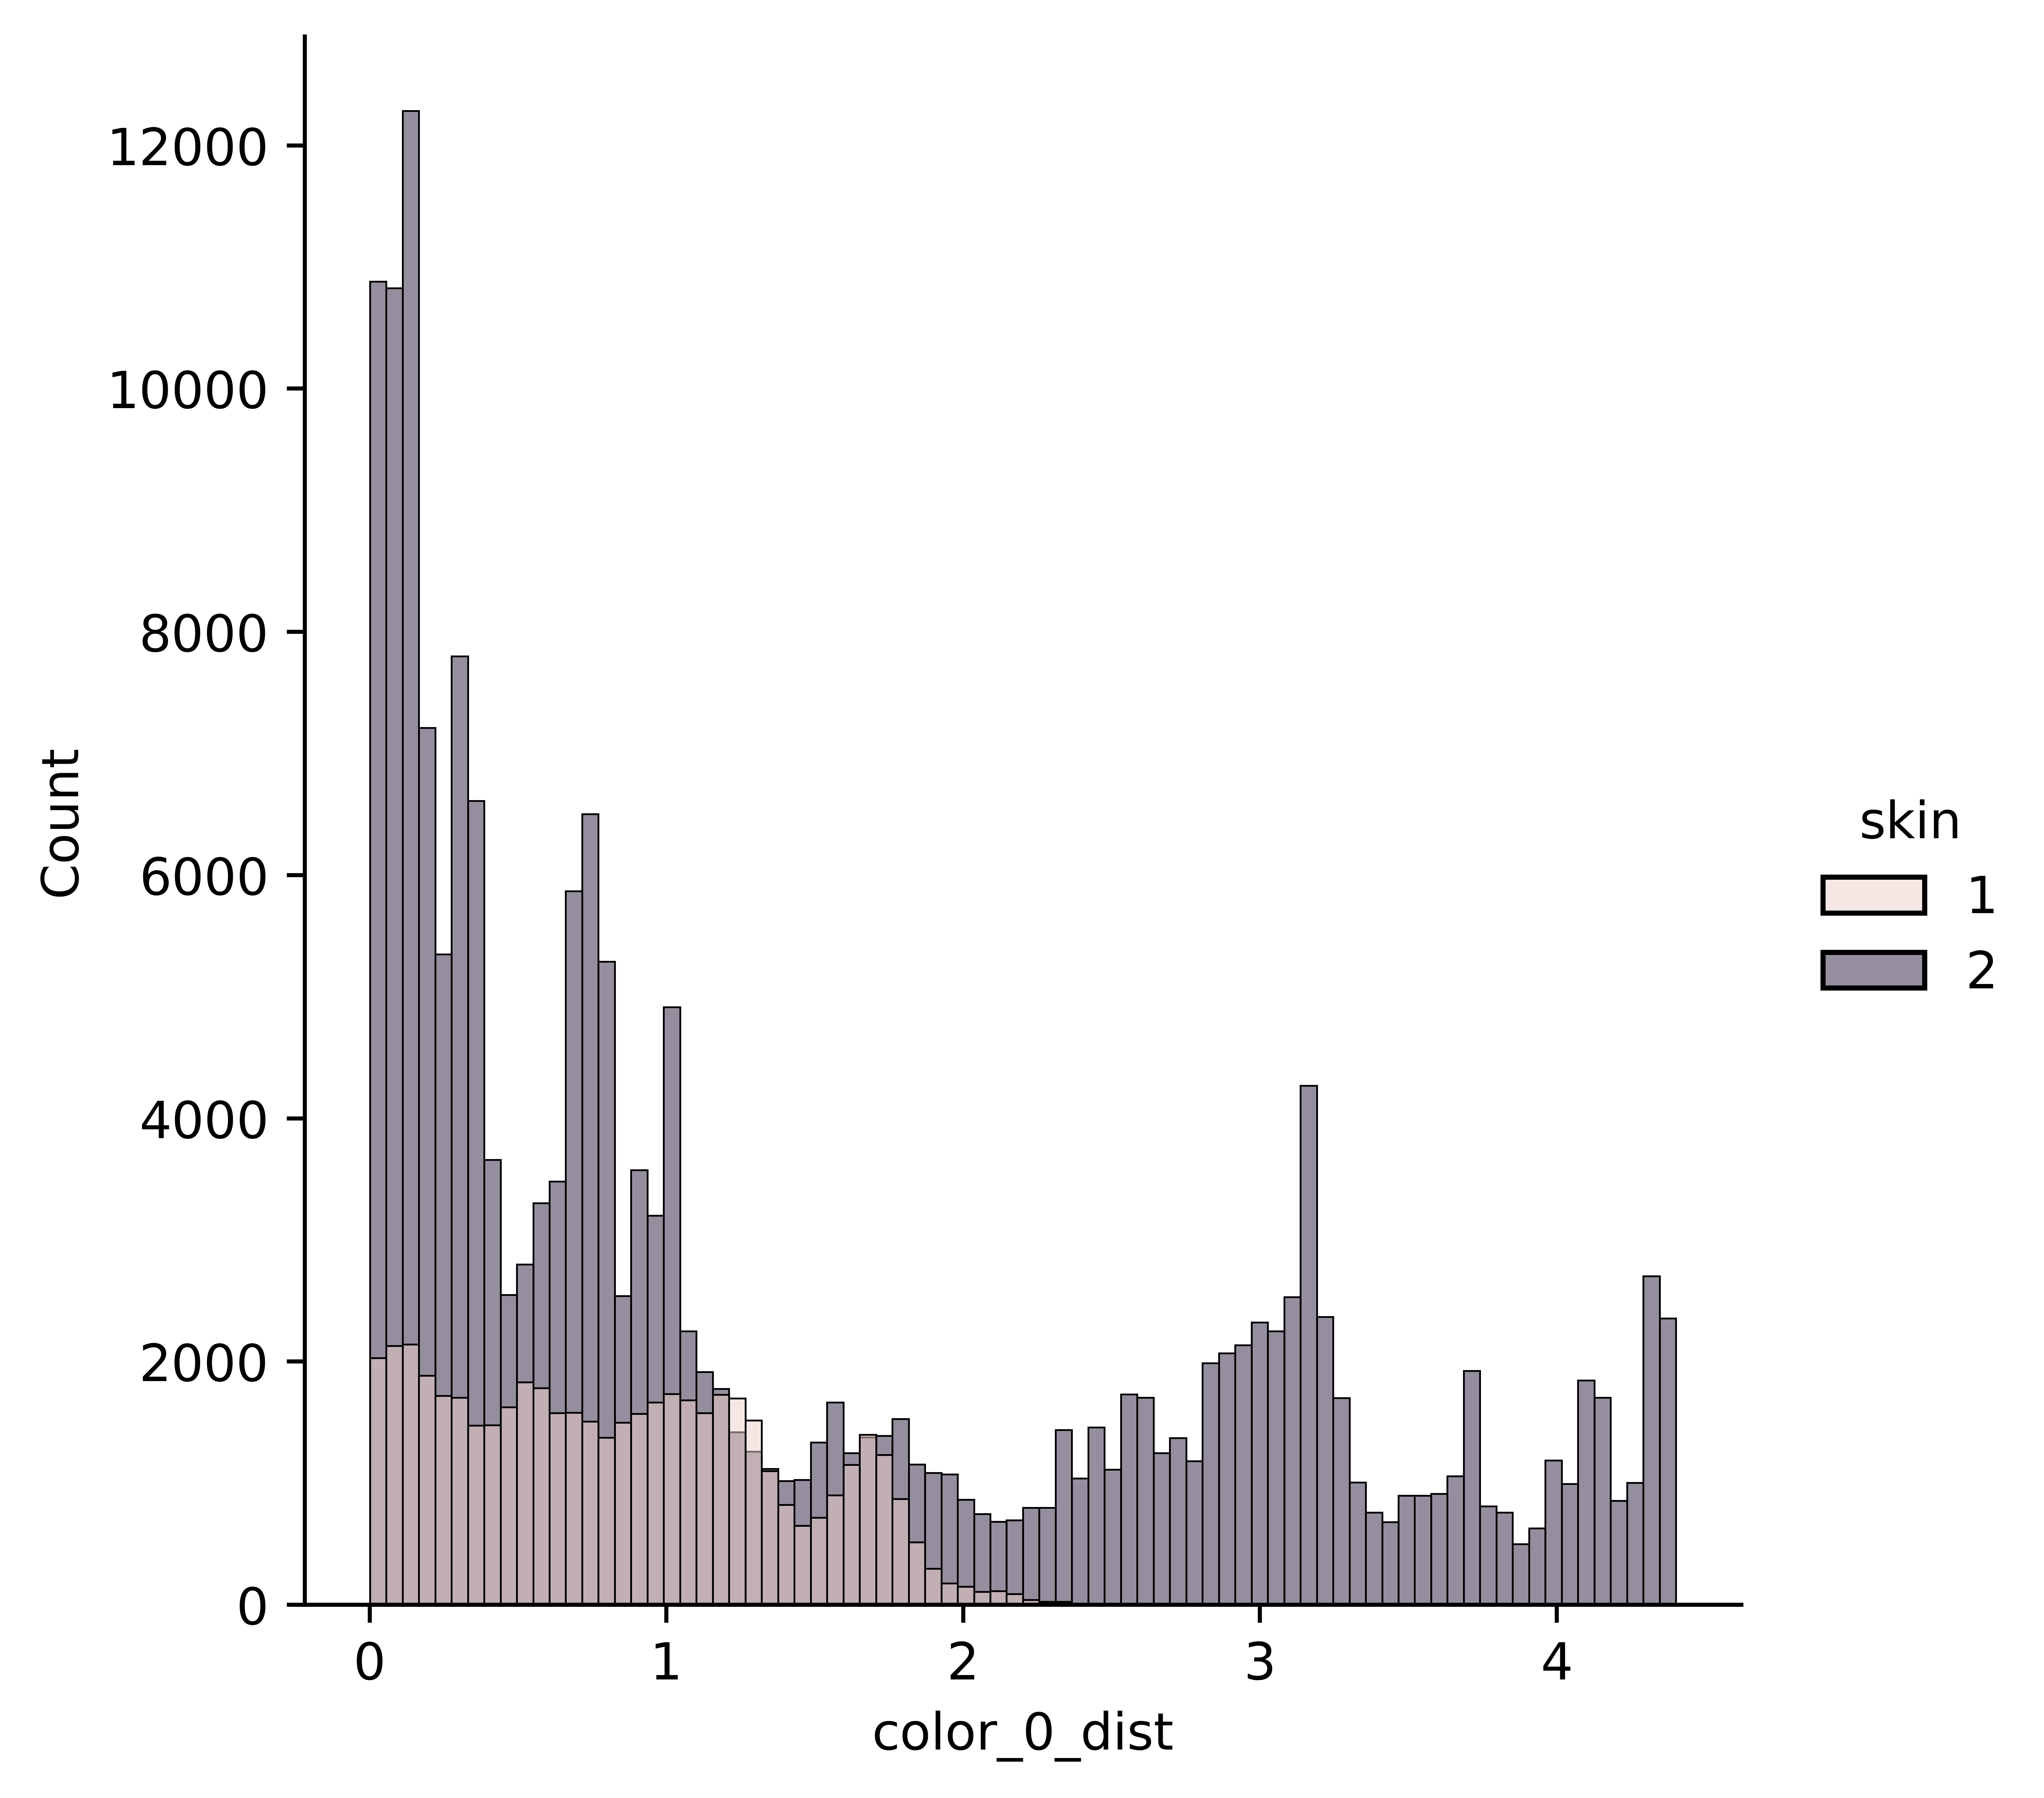

In [30]:
sns.displot(data=skin_data, x="color_0_dist", hue="skin")

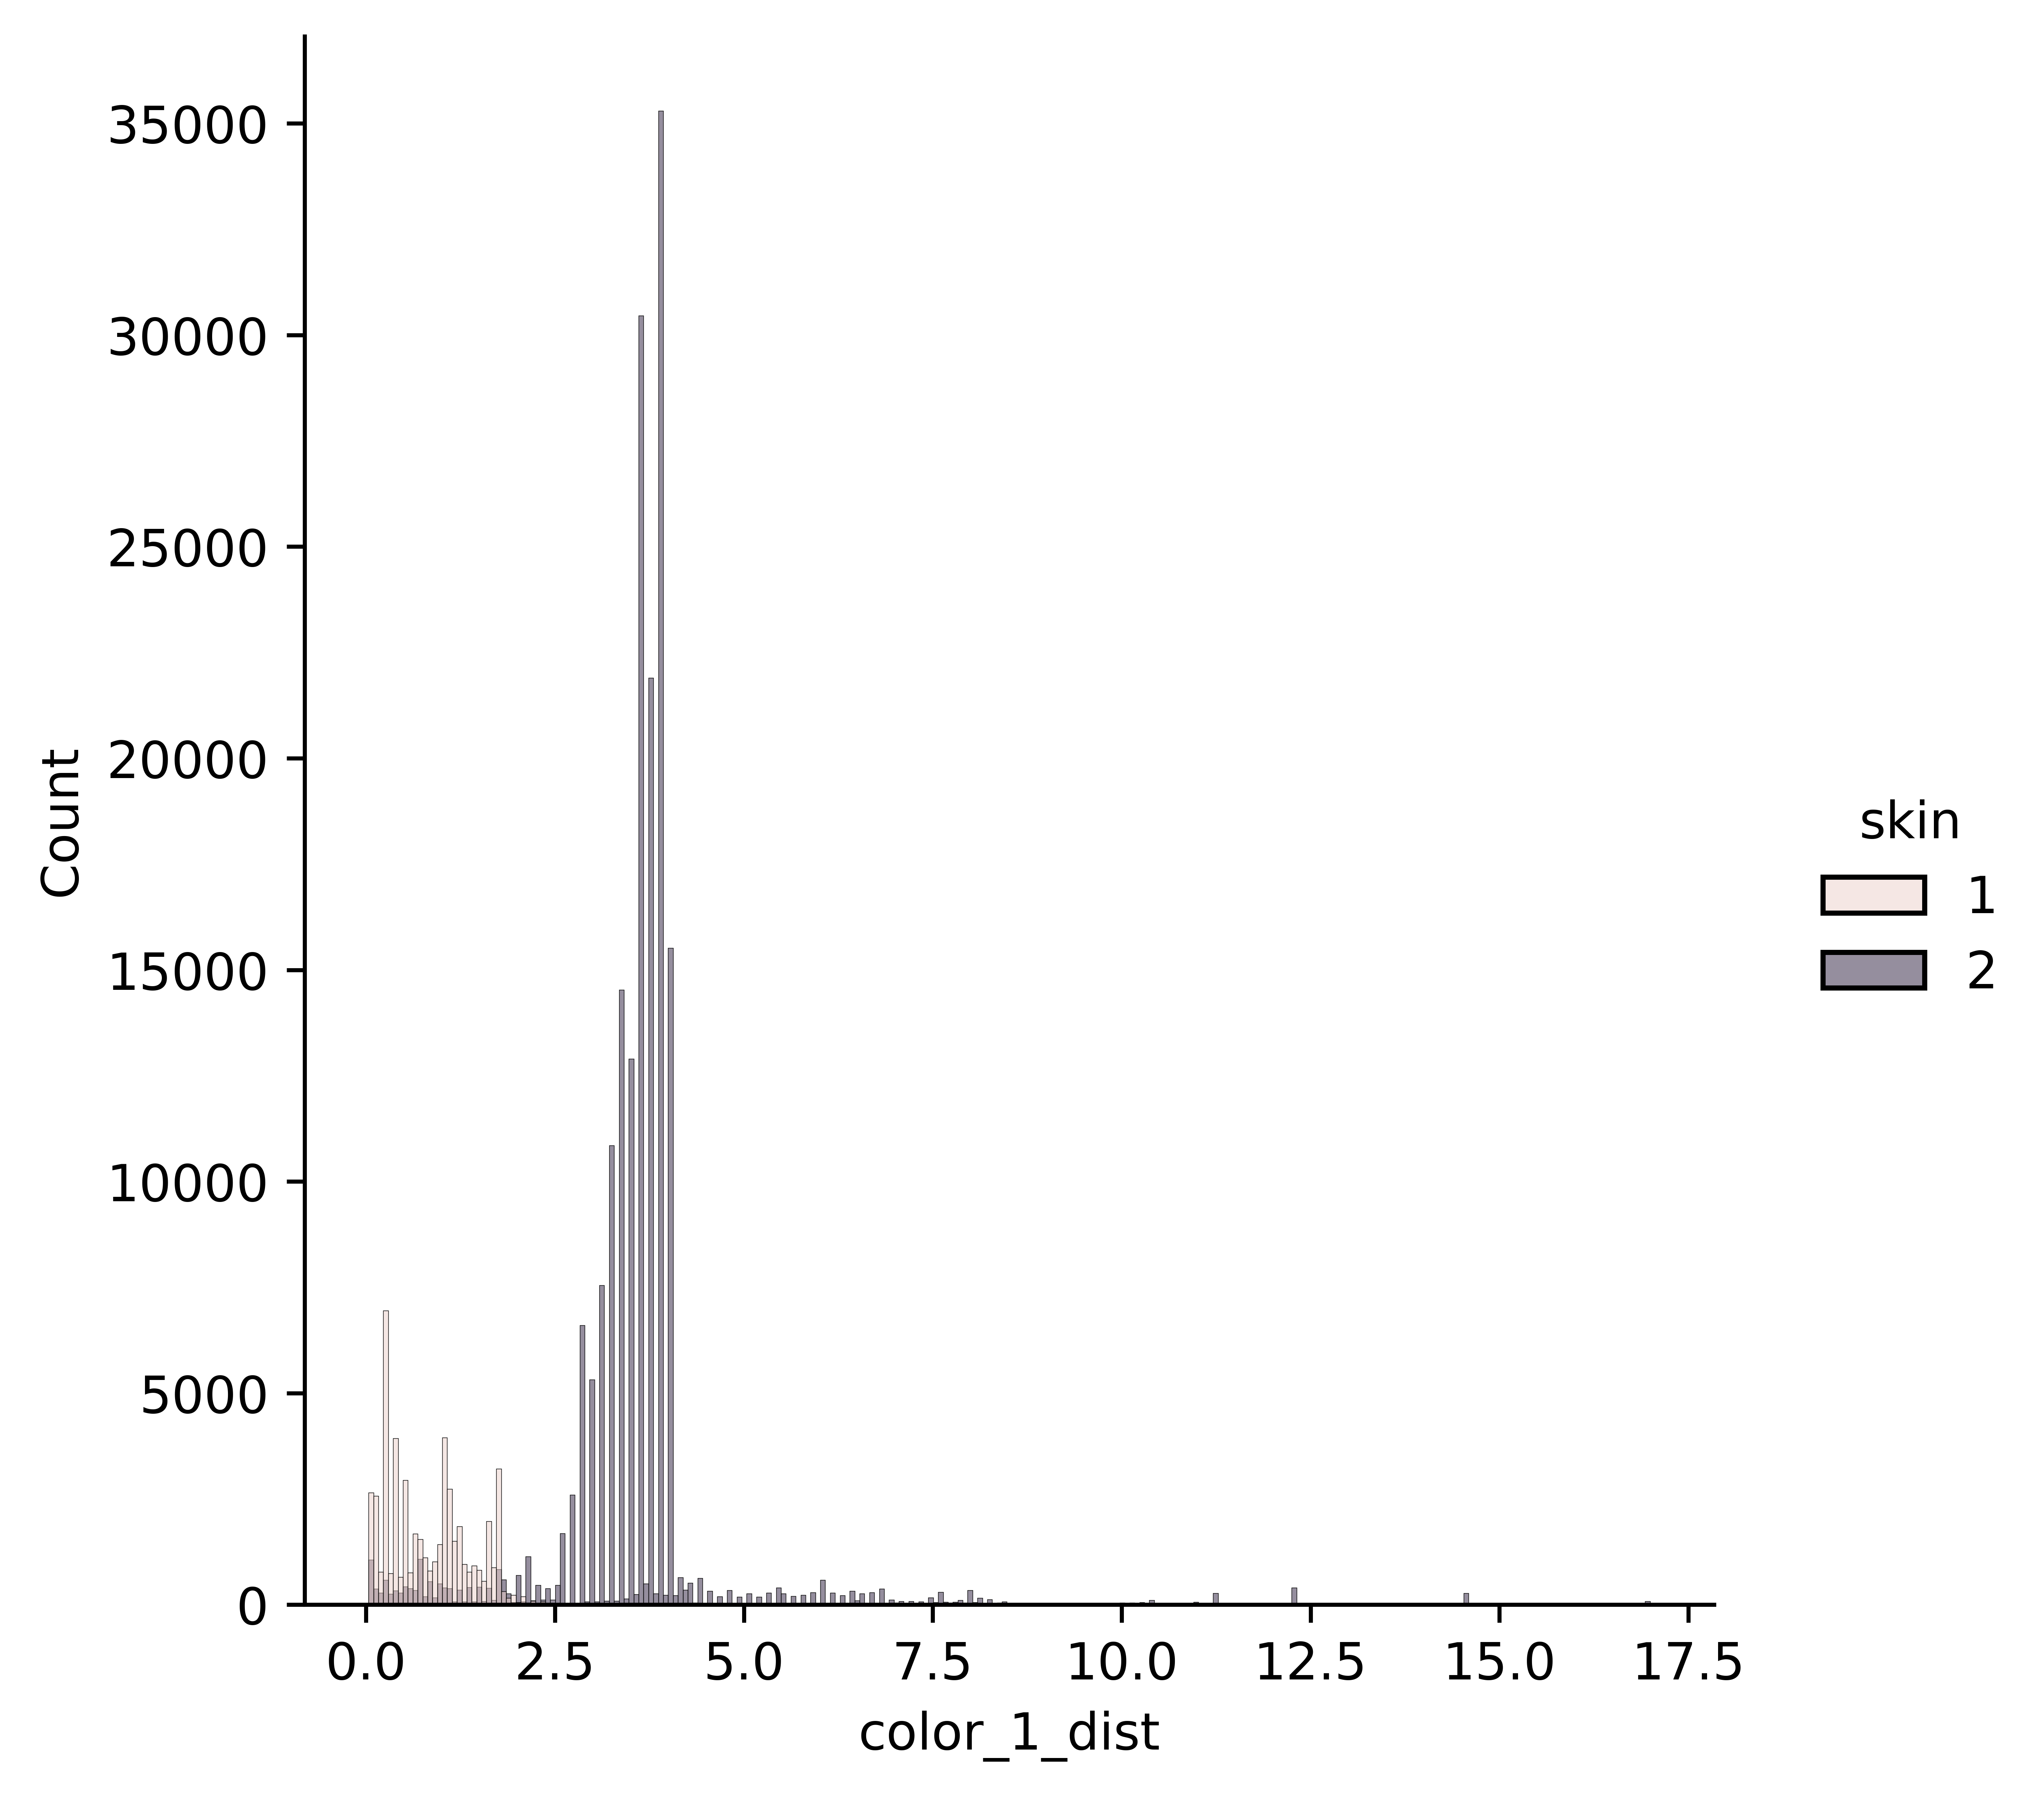

In [31]:
sns.displot(data=skin_data, x="color_1_dist", hue="skin")

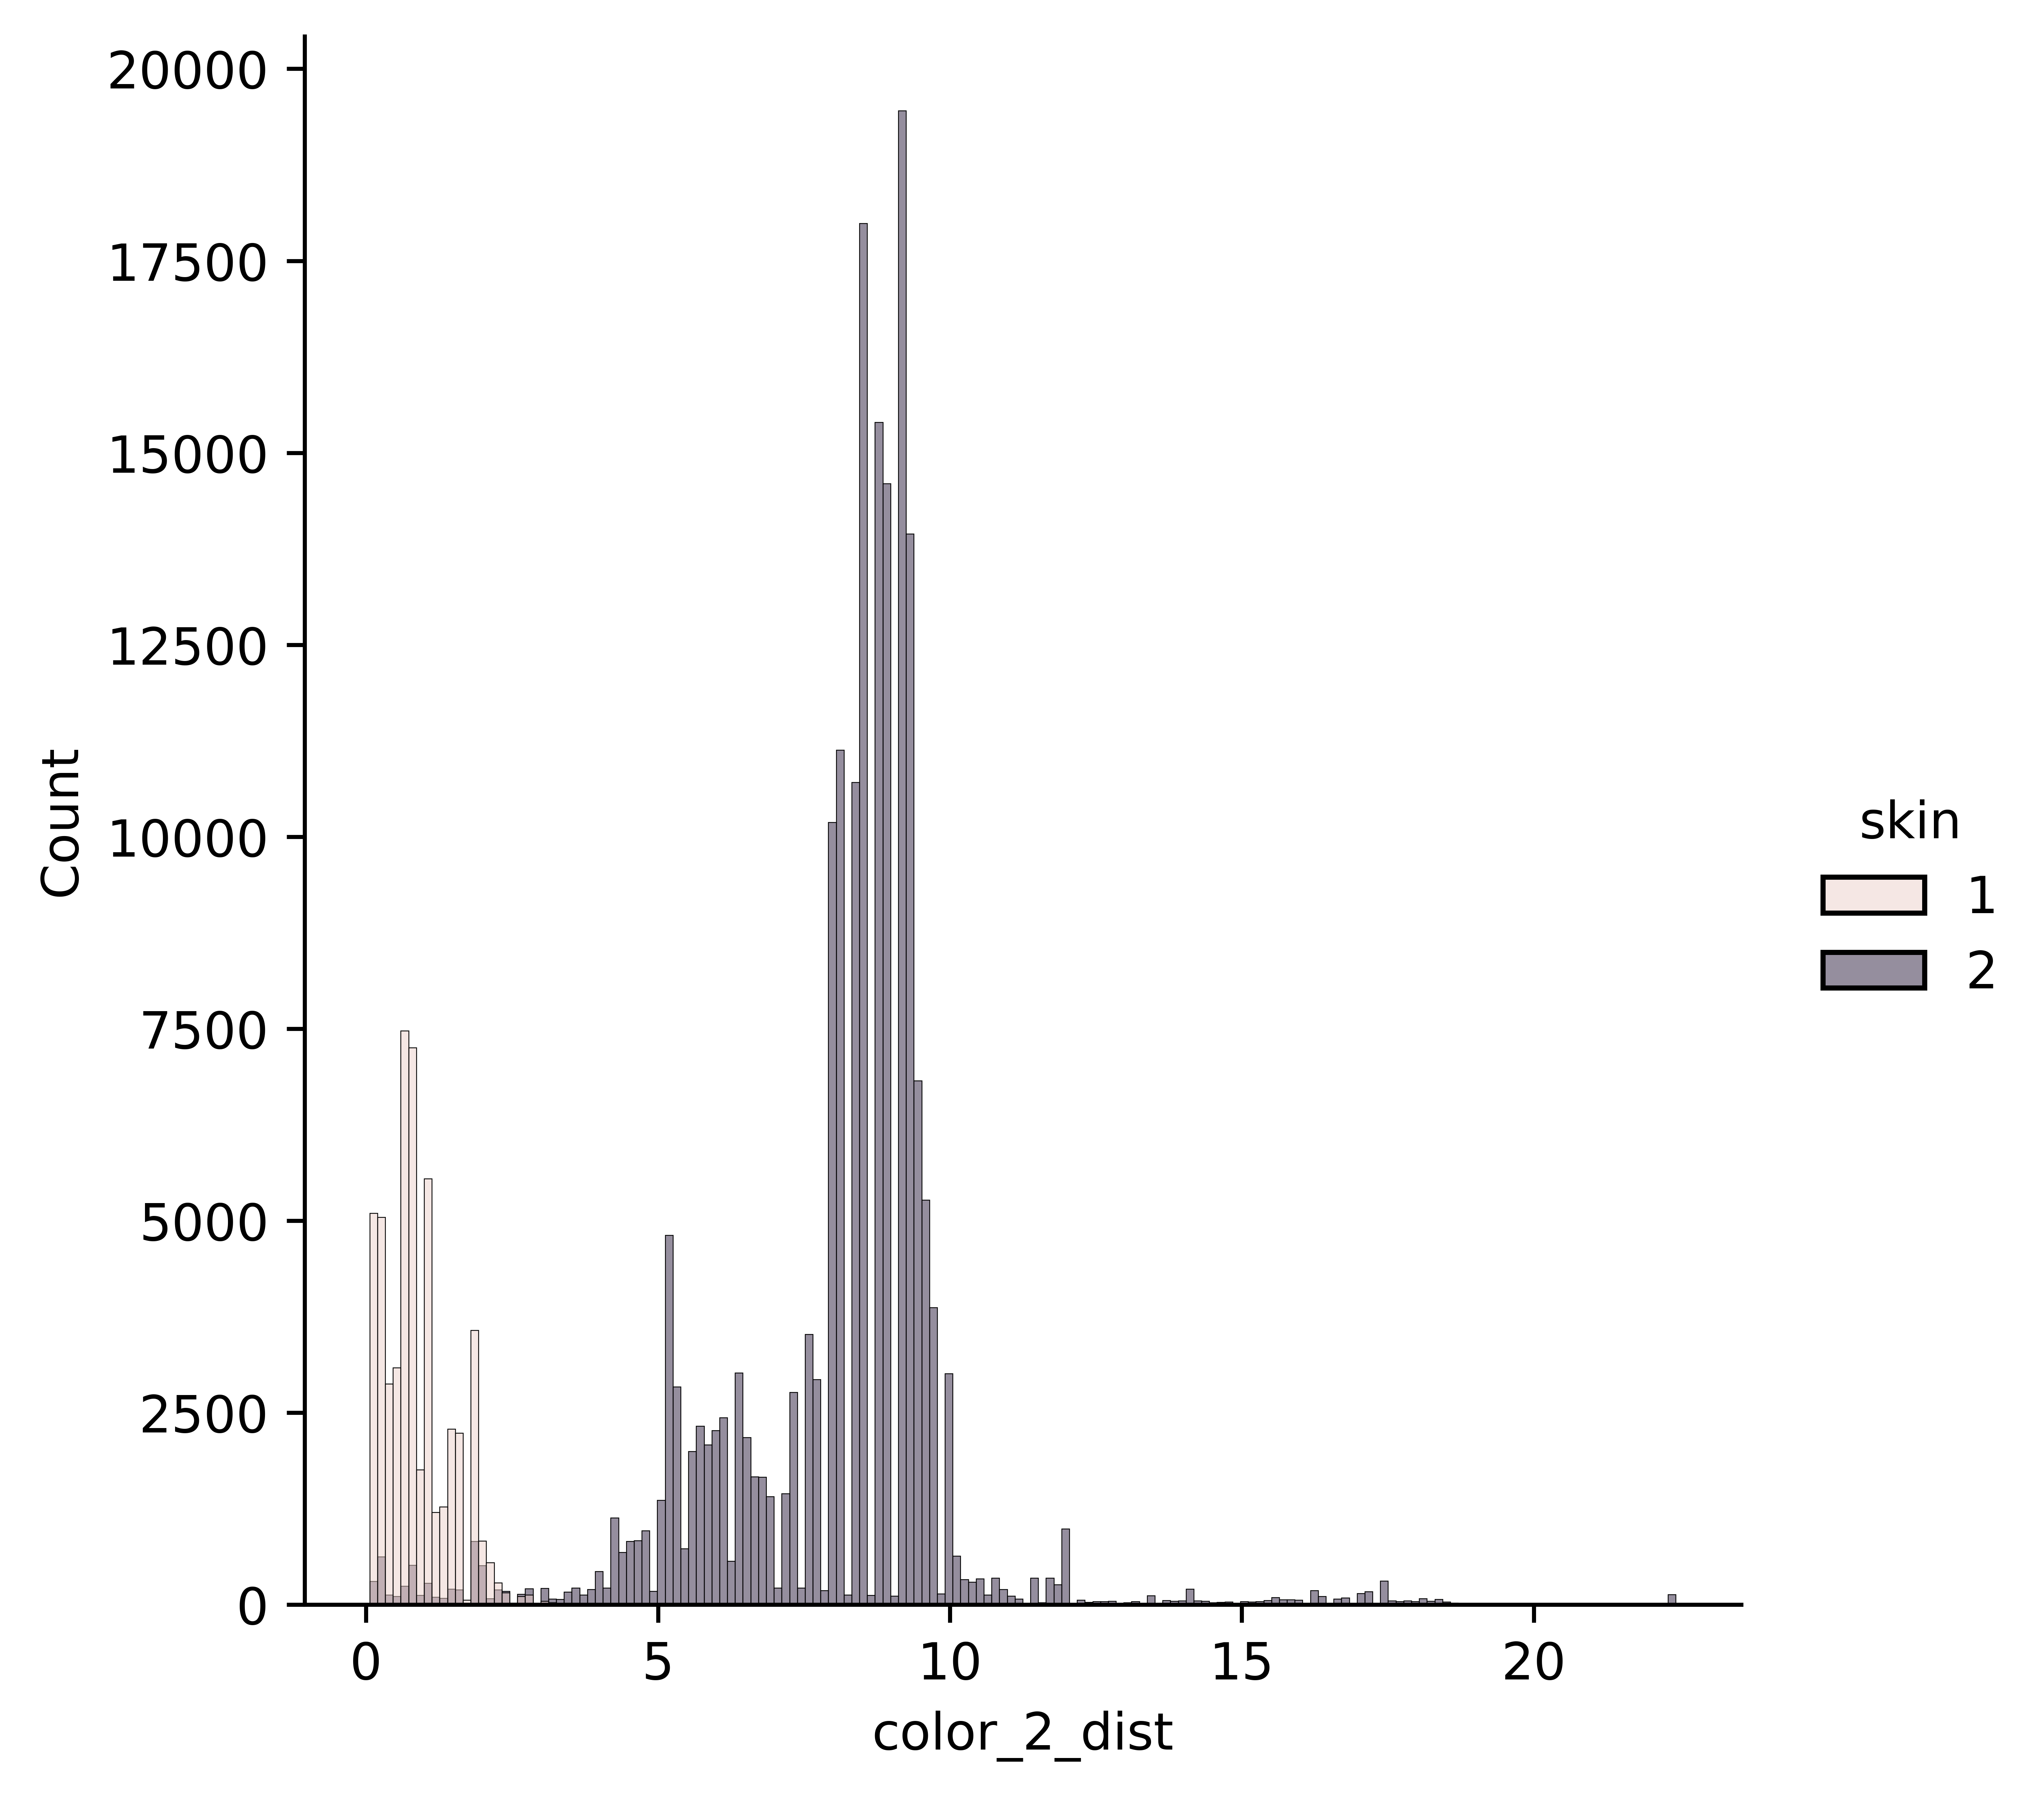

In [35]:
sns.displot(data=skin_data, x="color_2_dist", hue="skin")

In [36]:
list(range(3))

[0, 1, 2]

In [37]:
true_positives = [0,0,0]
false_positives = [0,0,0]
true_negatives = [0,0,0]
false_negatives = [0,0,0]
m_thresh = [0,0,0]
thresholds = [0,0,0]

In [38]:
for color_num in range(3):
    color_channel = "color_%d"%color_num
    true_positives[color_num] = np.zeros(THRESHOLD_COUNT)
    false_positives[color_num] = np.zeros(THRESHOLD_COUNT)
    true_negatives[color_num] = np.zeros(THRESHOLD_COUNT)
    false_negatives[color_num] = np.zeros(THRESHOLD_COUNT)


    color_data = skin_data.loc[:, ['skin', color_channel + '_dist']] 
    color_data["skin"] = color_data["skin"] == 1
    color_data.head()
    
    thresholds[color_num] = np.linspace(min(skin_data[color_channel + "_dist"]),
                                        max(skin_data[color_channel + "_dist"]),
                                        THRESHOLD_COUNT)
    total = color_data.count()[0]
    positives = color_data.loc[color_data["skin"]].count()[0]

    for threshold_index in range(len(thresholds[color_num])):
    # threshold_index = 0
#         print(color_channel + "_dist")
#         print(thresholds[color_num][threshold_index])
#         print(color_data[color_channel + "_dist"])
    
        color_data["prediction"] = color_data[color_channel + "_dist"] <= thresholds[color_num][threshold_index]
        true_positives[color_num][threshold_index] = color_data.loc[(color_data["skin"] == color_data["prediction"]) &  color_data["prediction"]].count()[0]
        true_negatives[color_num][threshold_index] = color_data.loc[(color_data["skin"] == color_data["prediction"]) &  ~color_data["prediction"]].count()[0]
        false_positives[color_num][threshold_index] = color_data.loc[(color_data["skin"] != color_data["prediction"]) &  color_data["prediction"]].count()[0]
        false_negatives[color_num][threshold_index] = color_data.loc[(color_data["skin"] != color_data["prediction"]) &  ~color_data["prediction"]].count()[0]
    # color_data.head()

    m_thresh[color_num] = (1.0 - false_positives[color_num]/(total - positives)) + ((true_positives[color_num]/positives) * 10)

    THRESHOLD[color_num] = min(thresholds[color_num][np.argmax(m_thresh[color_num])], thresholds[color_num][-1])
    MODEL[color_num] = [hsv_skin_model_mean[color_num], hsv_skin_model_std[color_num]]

<AxesSubplot:>

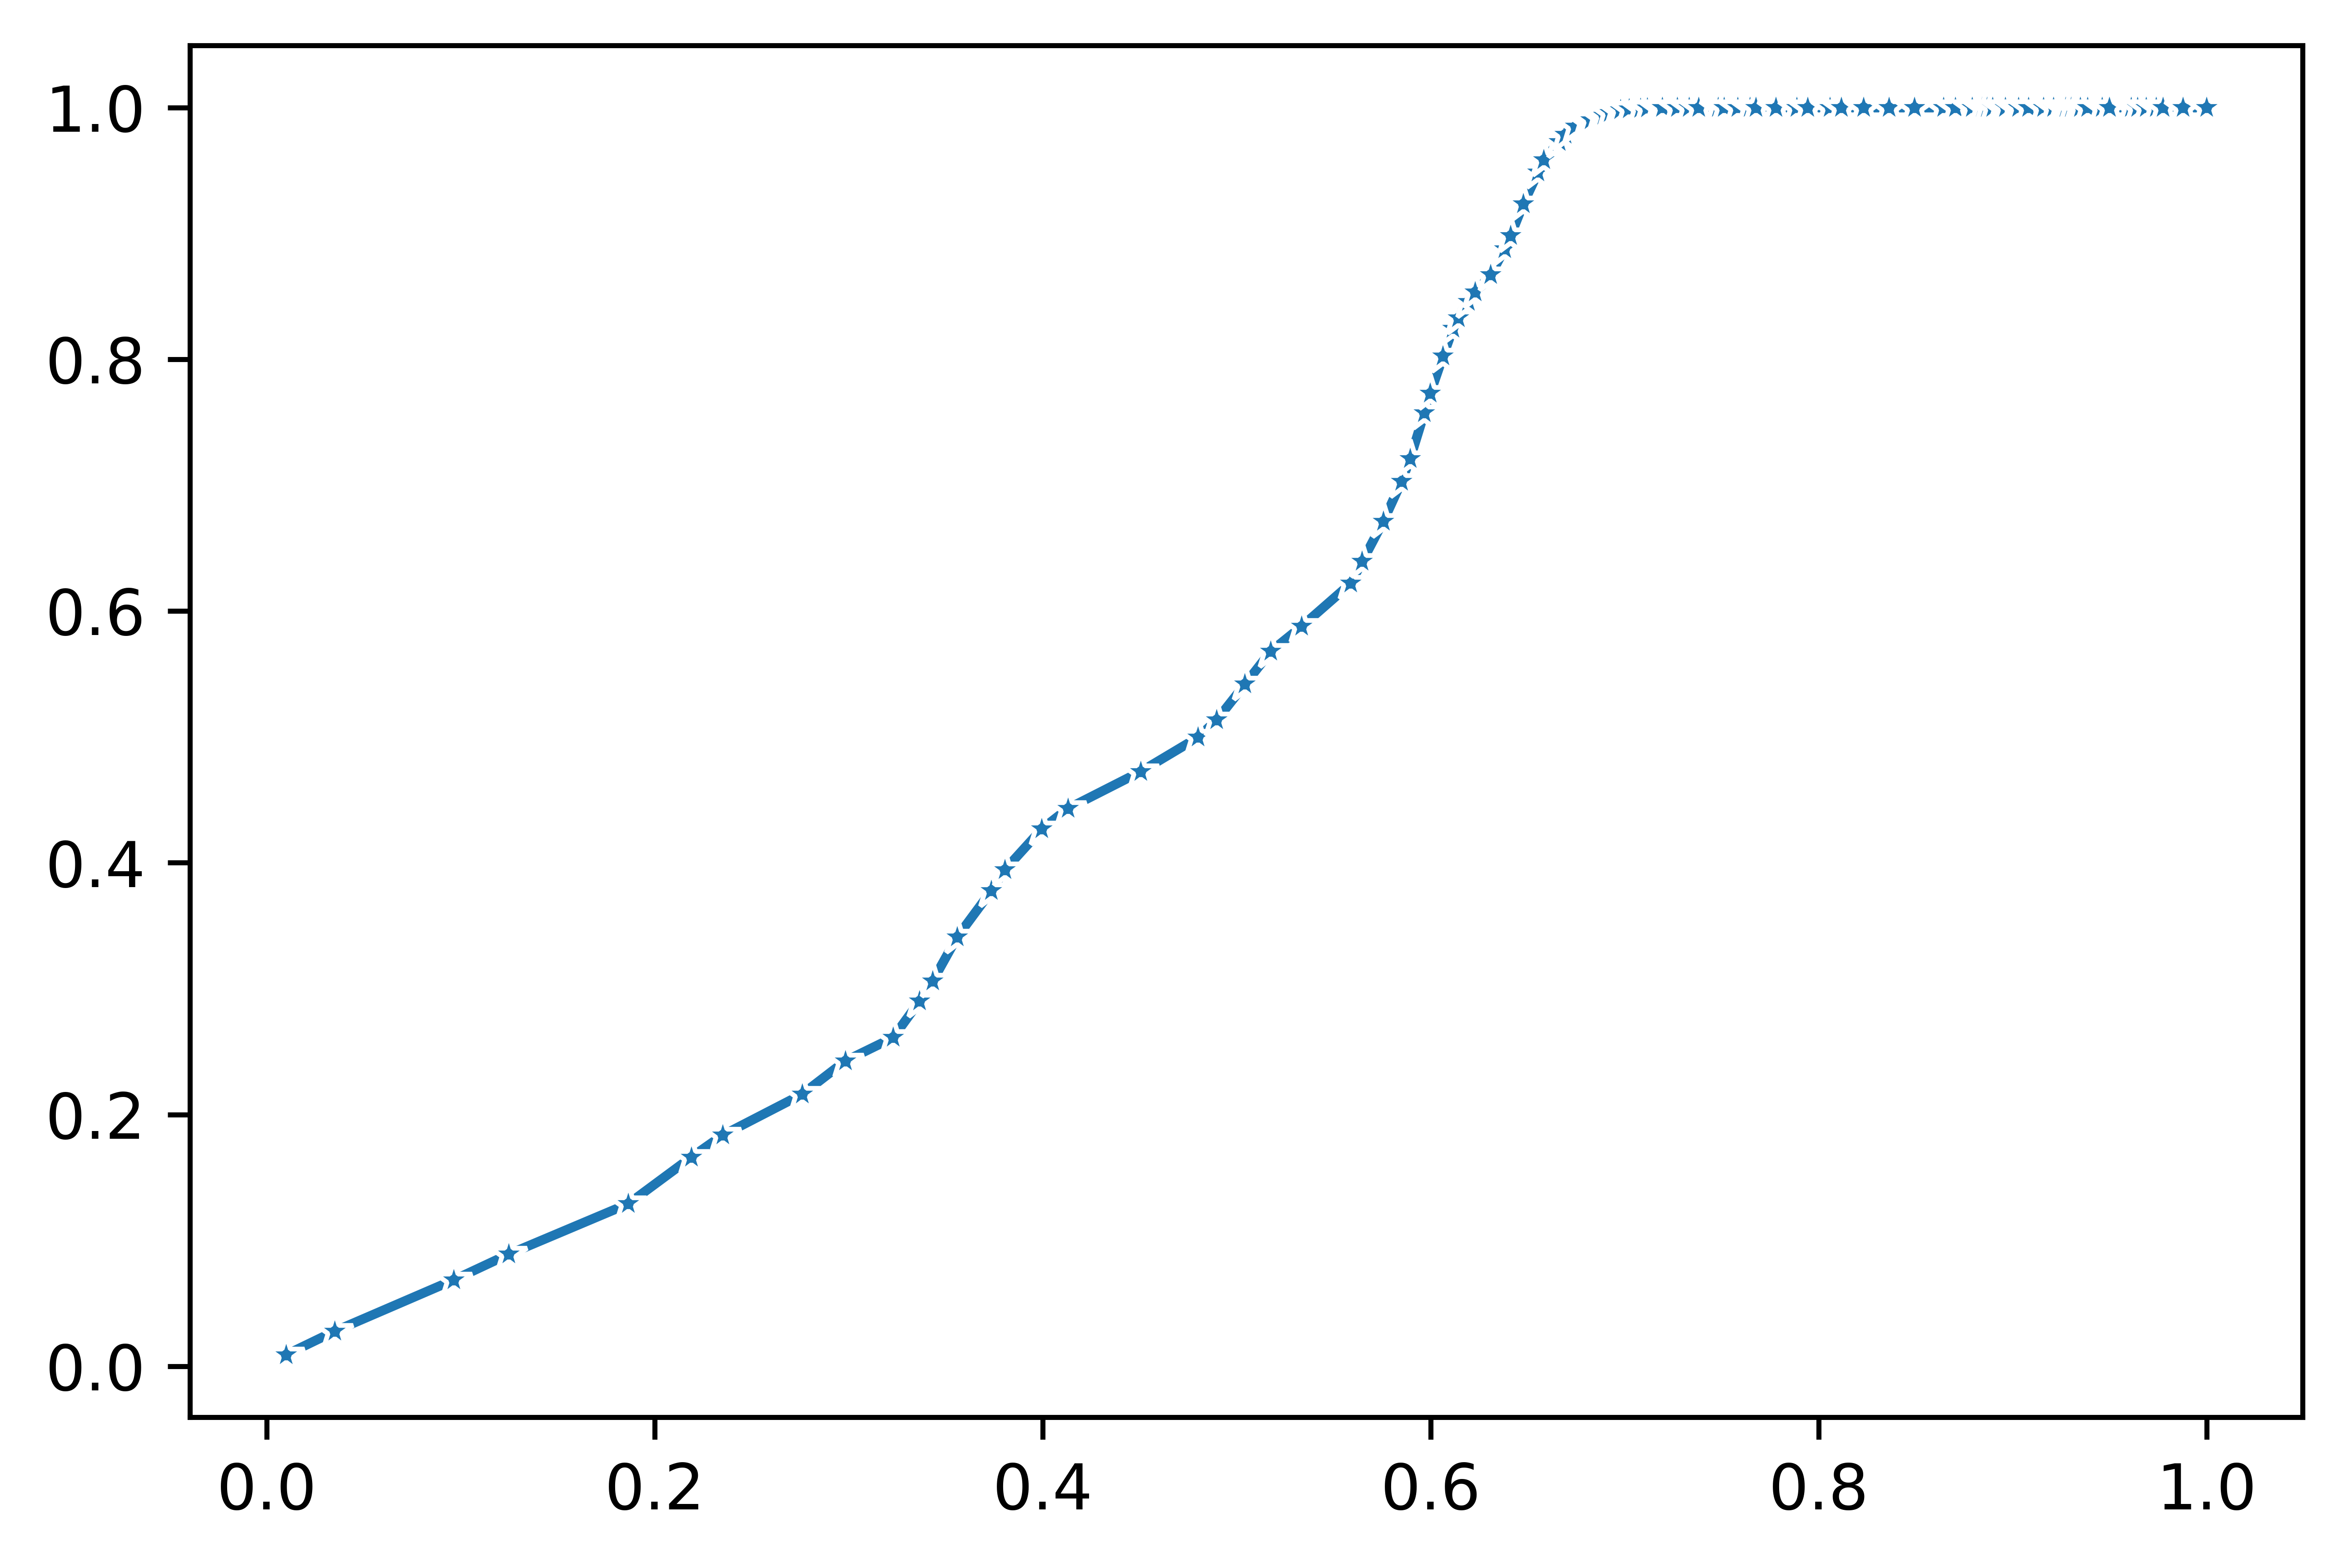

In [39]:
sns.lineplot(x=false_positives[0]/(total - positives), y=true_positives[0]/positives, marker='*')

<AxesSubplot:>

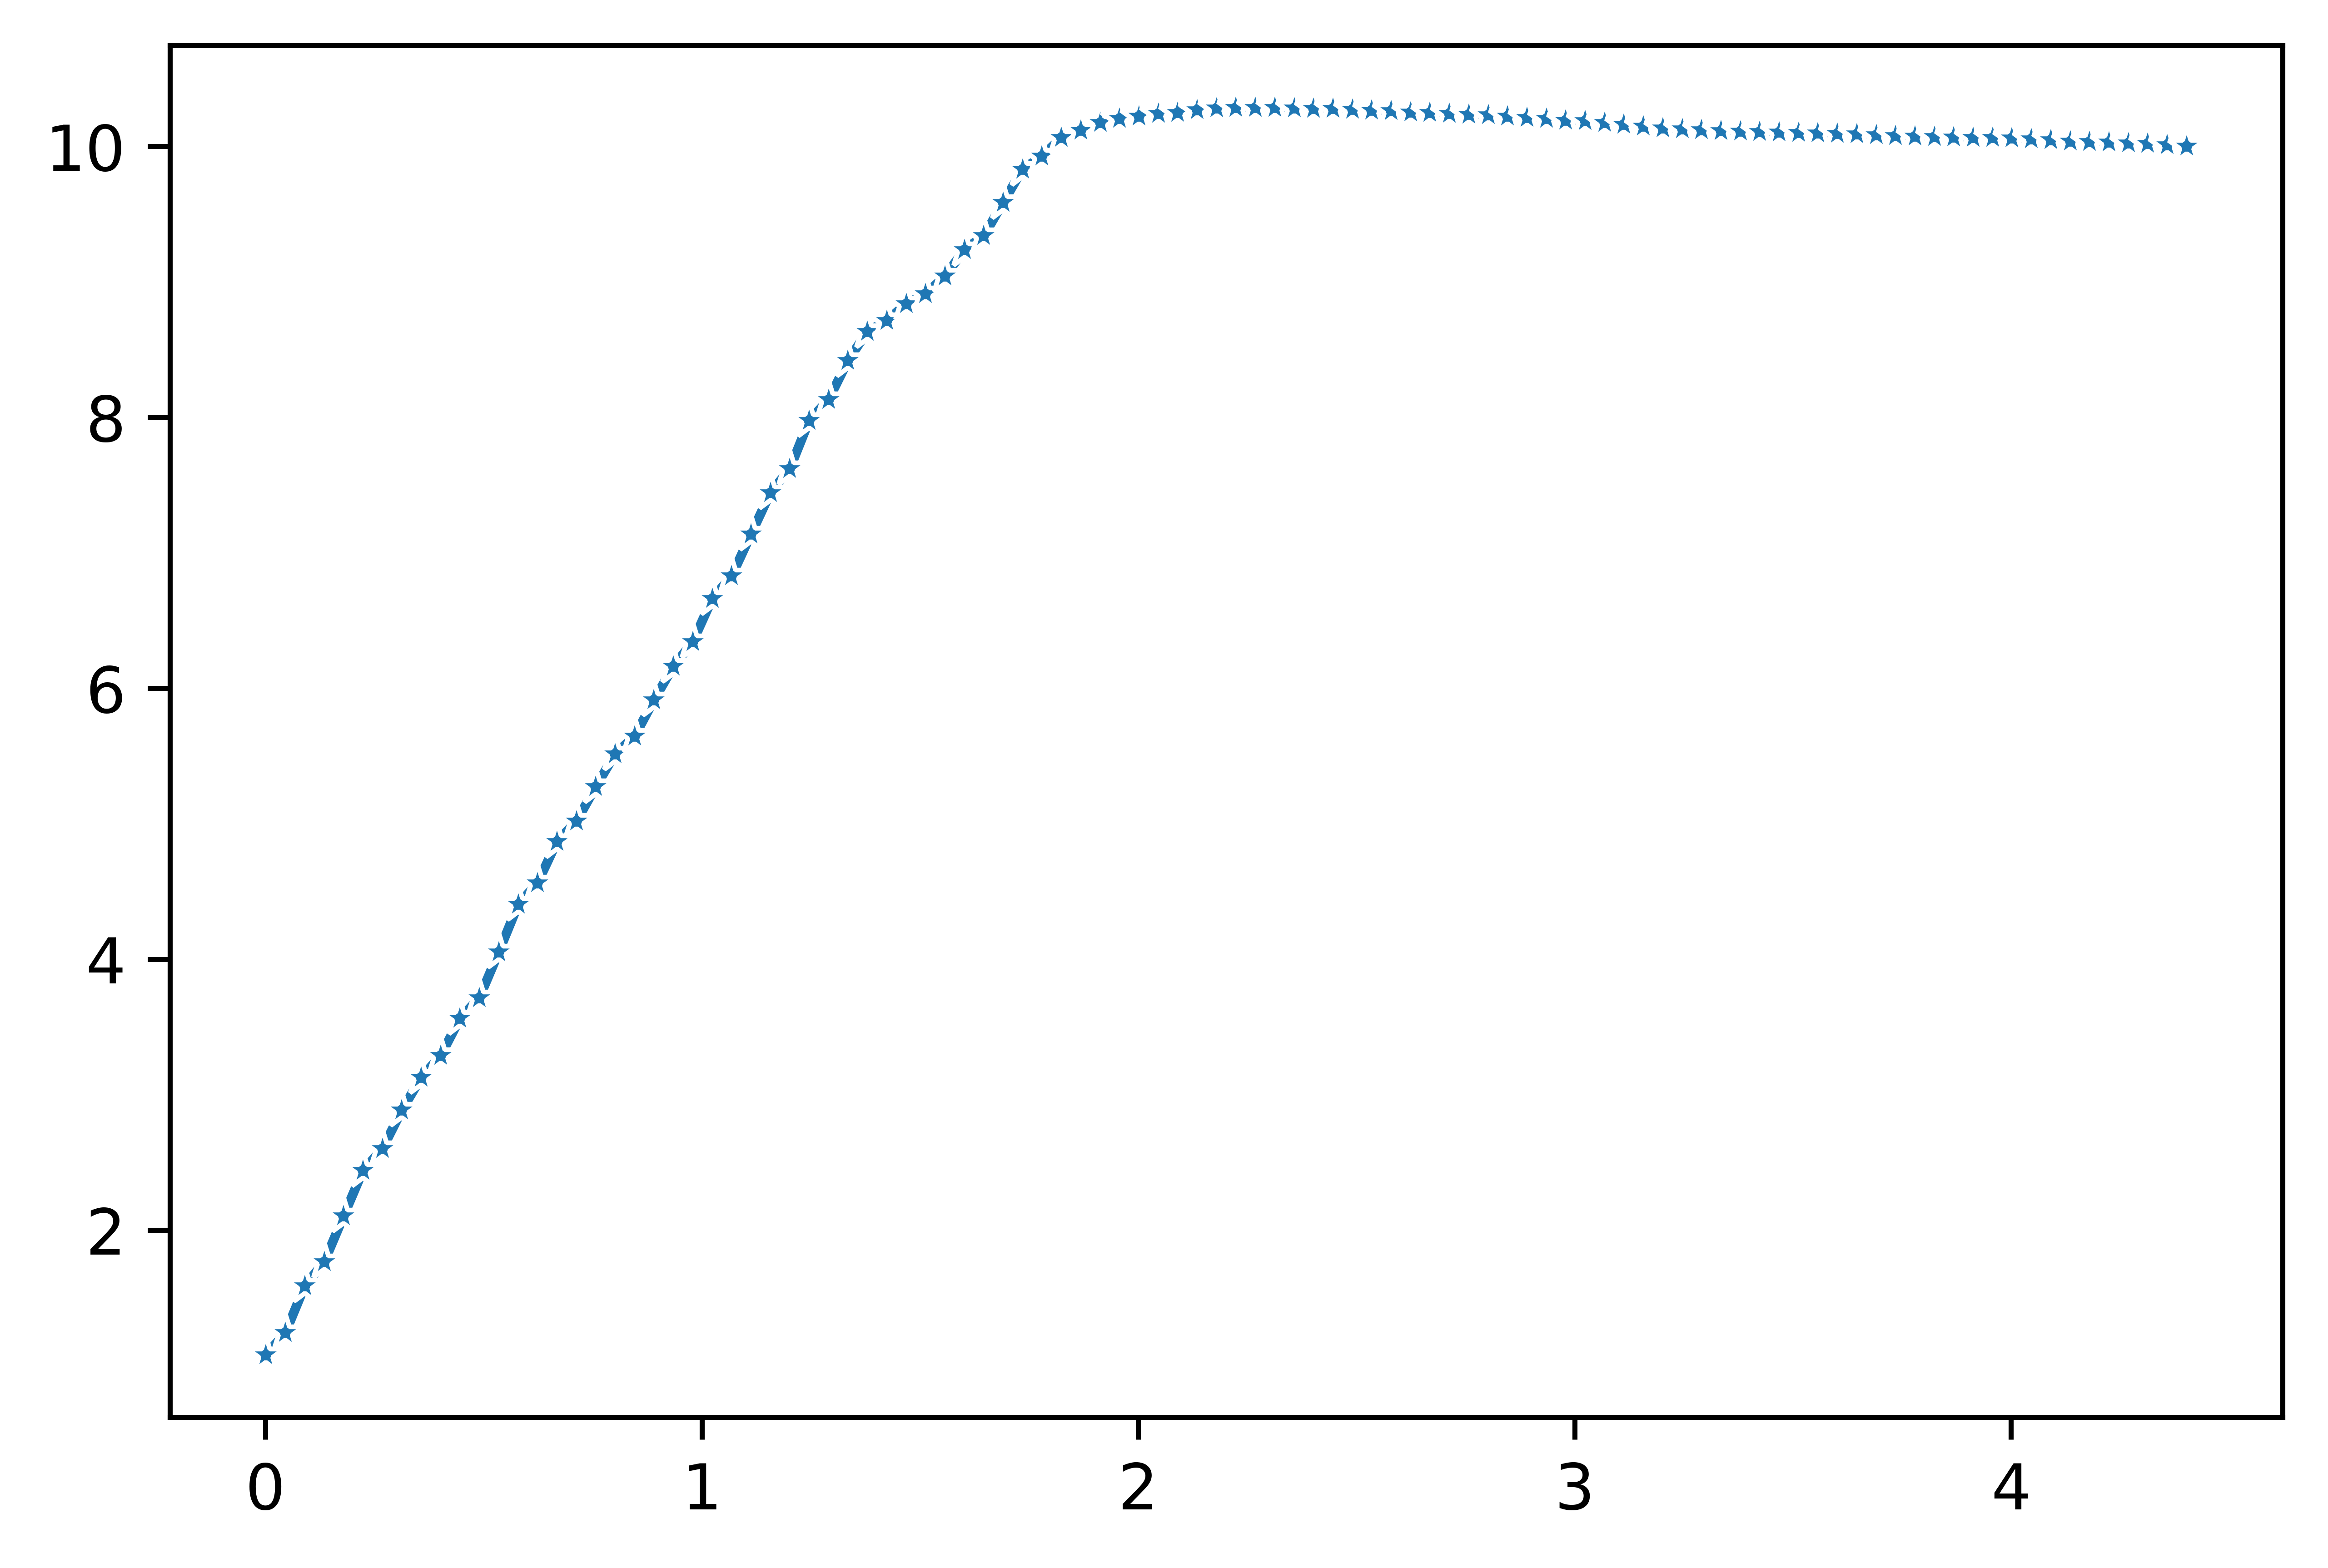

In [40]:
sns.lineplot(x=thresholds[0], y=m_thresh[0], marker='*')

In [ ]:
# H_THRESHOLD[0] = min(thresholds[np.argmax(m_thresh)], thresholds[-1])
# H_MODEL = [hsv_skin_model_mean[0], hsv_skin_model_std[0]]

In [ ]:
# H_THRESHOLD = min(thresholds[np.argmax(m_thresh)], thresholds[-1])
# H_THRESHOLD

In [ ]:
# H_MODEL = [hsv_skin_model_mean[COLOR_CHANNEL_NUM], hsv_skin_model_std[COLOR_CHANNEL_NUM]]
# H_MODEL

In [ ]:
# hsv_skin_model_mean[COLOR_CHANNEL_NUM]


In [ ]:
# hsv_skin_model_std[COLOR_CHANNEL_NUM]

In [22]:
im = cv2.imread("opencv_frame_0.png")
new_im = im.copy()

In [ ]:
plt.imshow(im)

In [23]:
new_im[...,0] = im[...,2]
new_im[...,1] = im[...,1]
new_im[...,2] = im[...,0]

In [24]:
space_im = cv2.cvtColor(np.uint8(new_im), COLOR_SPACE)

In [57]:
flattened = np.reshape(im, (np.product(space_im.shape[:-1]), 3))
print(flattened[:5])

[[211 204 207]
 [211 204 207]
 [210 203 206]
 [210 203 206]
 [209 202 205]]


In [58]:
MODEL_MEAN = np.reshape(np.array(MODEL)[:,0], (1,3))
MODEL_STD= np.reshape(np.array(MODEL)[:,1], (1,3))
print(MODEL_MEAN)
print(MODEL_STD)

[[160.04351246 105.27776795 166.50958532]]
[[36.35529824  7.86886577  7.42187286]]


In [59]:
flat_normed = np.abs((flattened - MODEL_MEAN)/MODEL_STD)
print(flat_normed[:5])

[[ 1.4016248  12.54592909  5.45555218]
 [ 1.4016248  12.54592909  5.45555218]
 [ 1.37411849 12.41884598  5.3208153 ]
 [ 1.37411849 12.41884598  5.3208153 ]
 [ 1.34661218 12.29176286  5.18607842]]


In [60]:
predicted = model.predict(flat_normed)

In [61]:
print(predicted[:5])

[2 2 2 2 2]


In [62]:
predicted_im = np.reshape(1 - (predicted-1), space_im.shape[:-1])

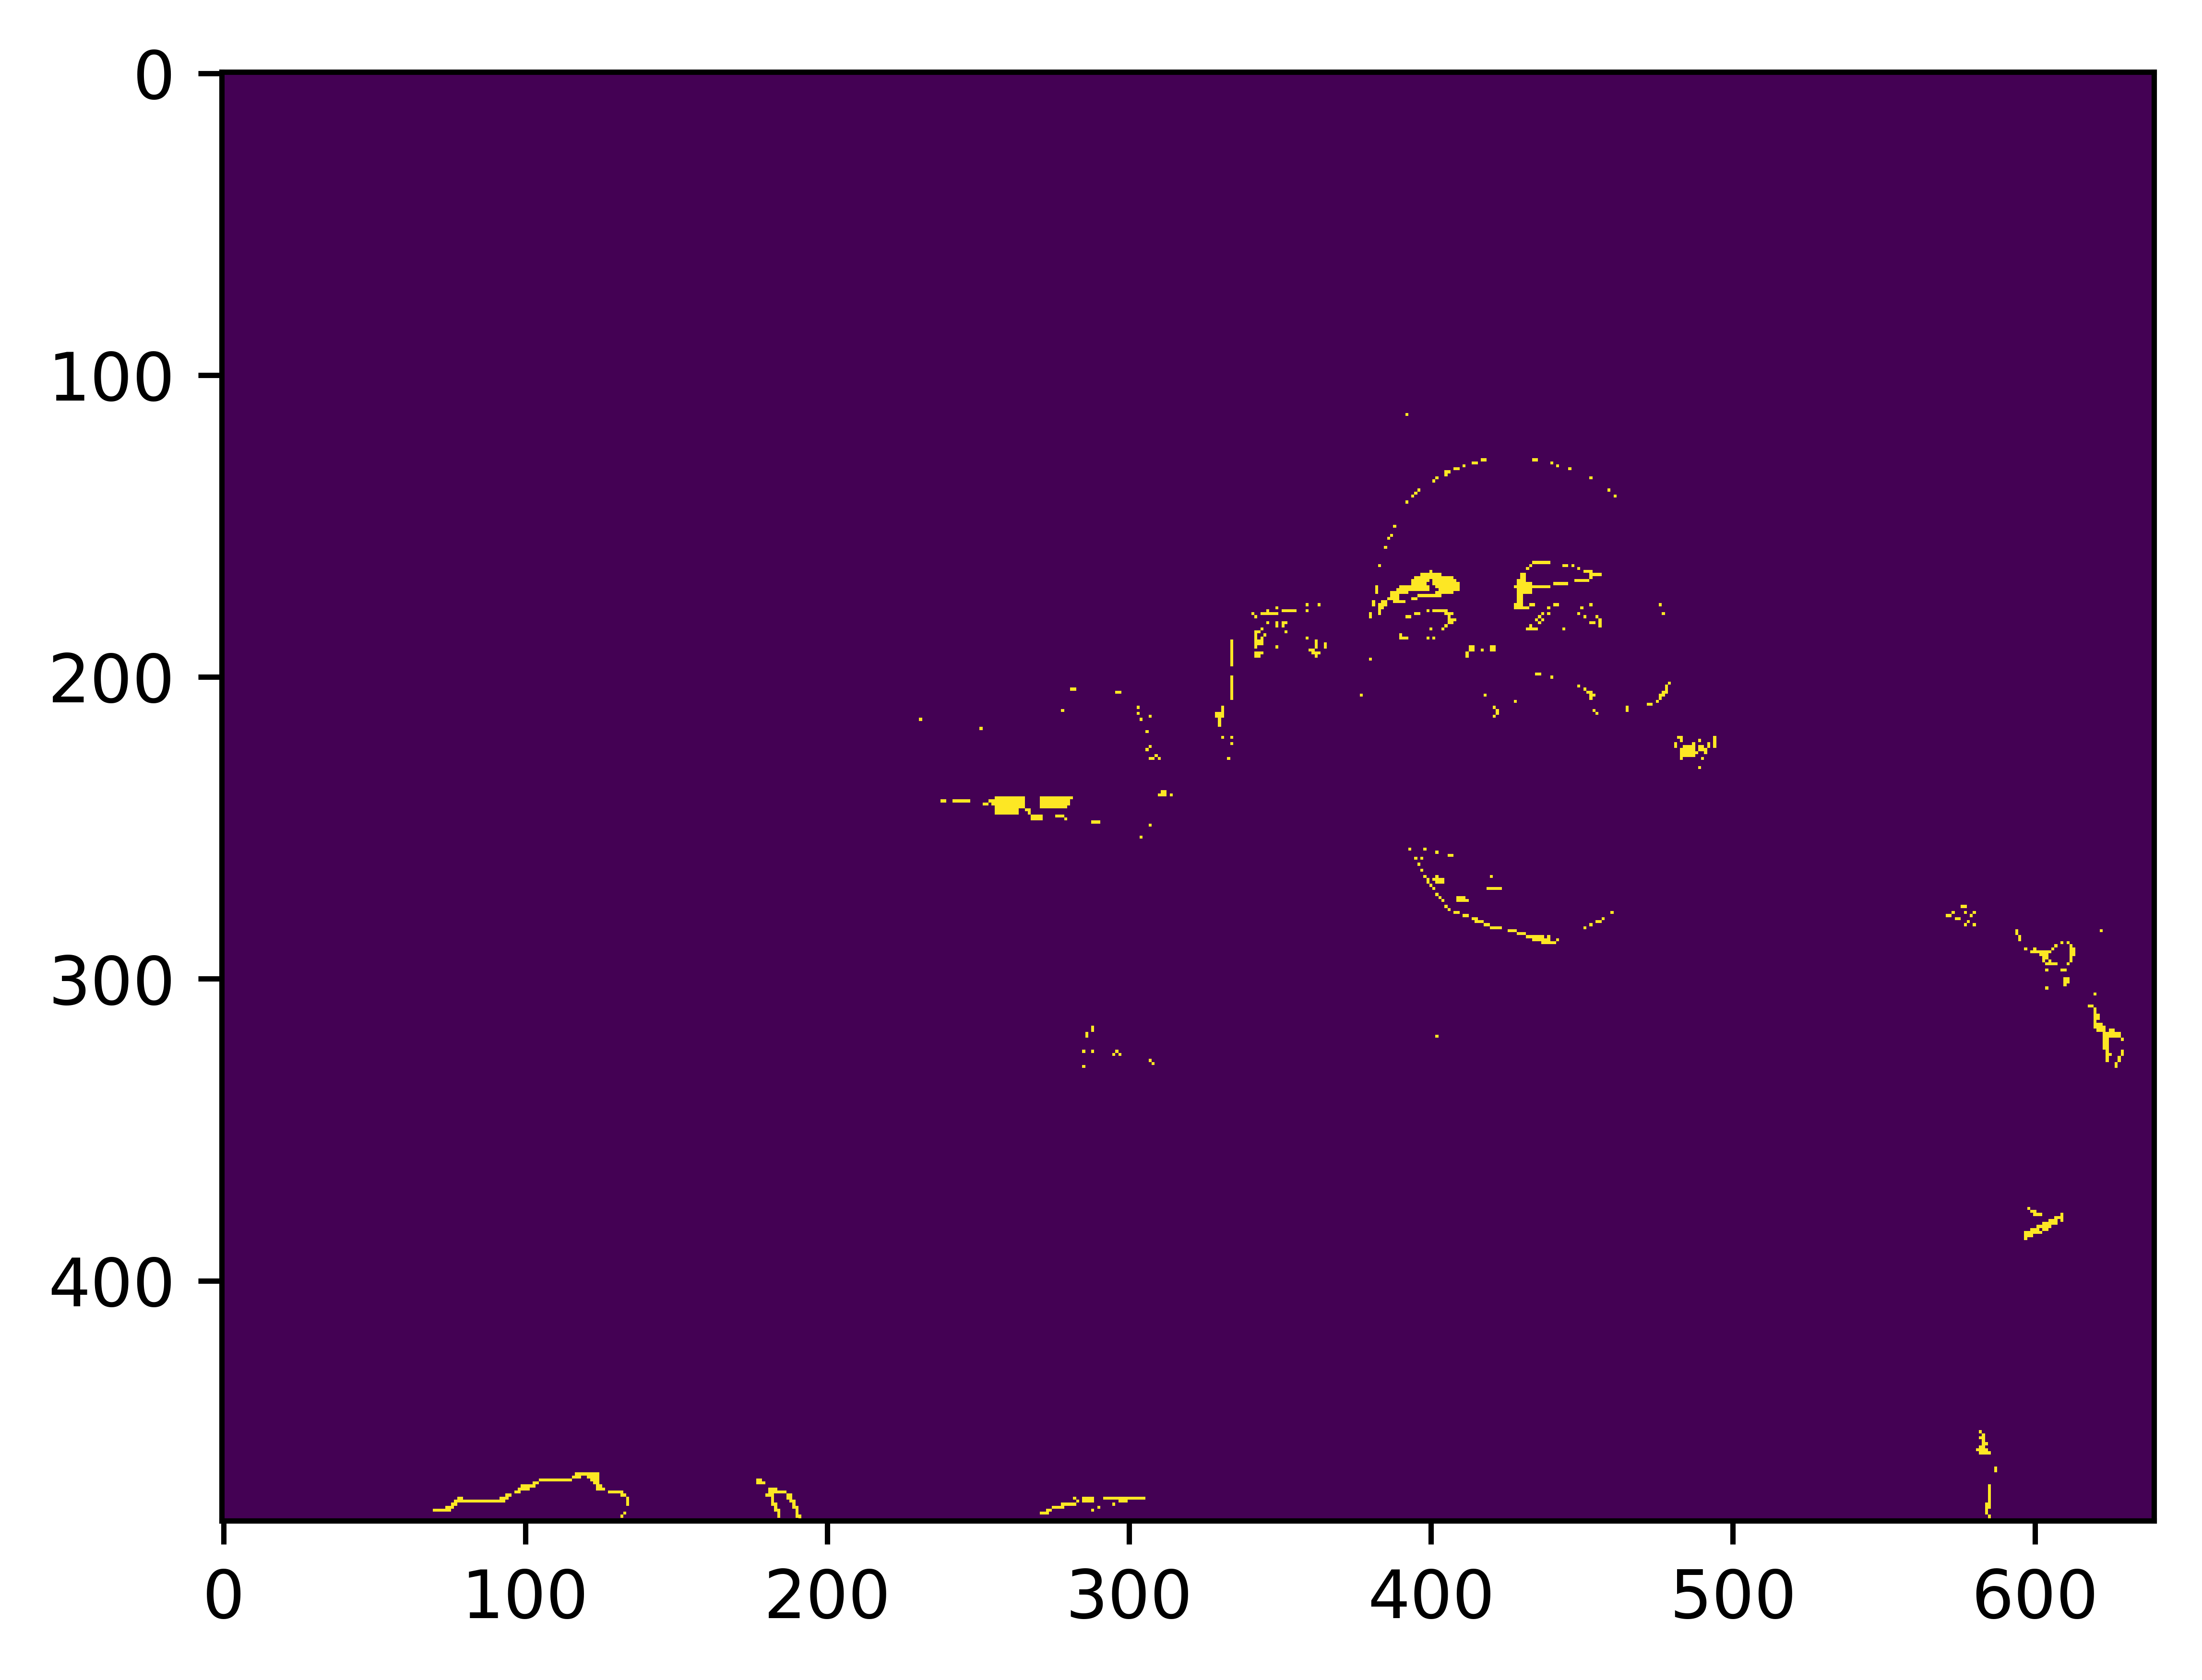

In [63]:
plt.imshow(predicted_im)

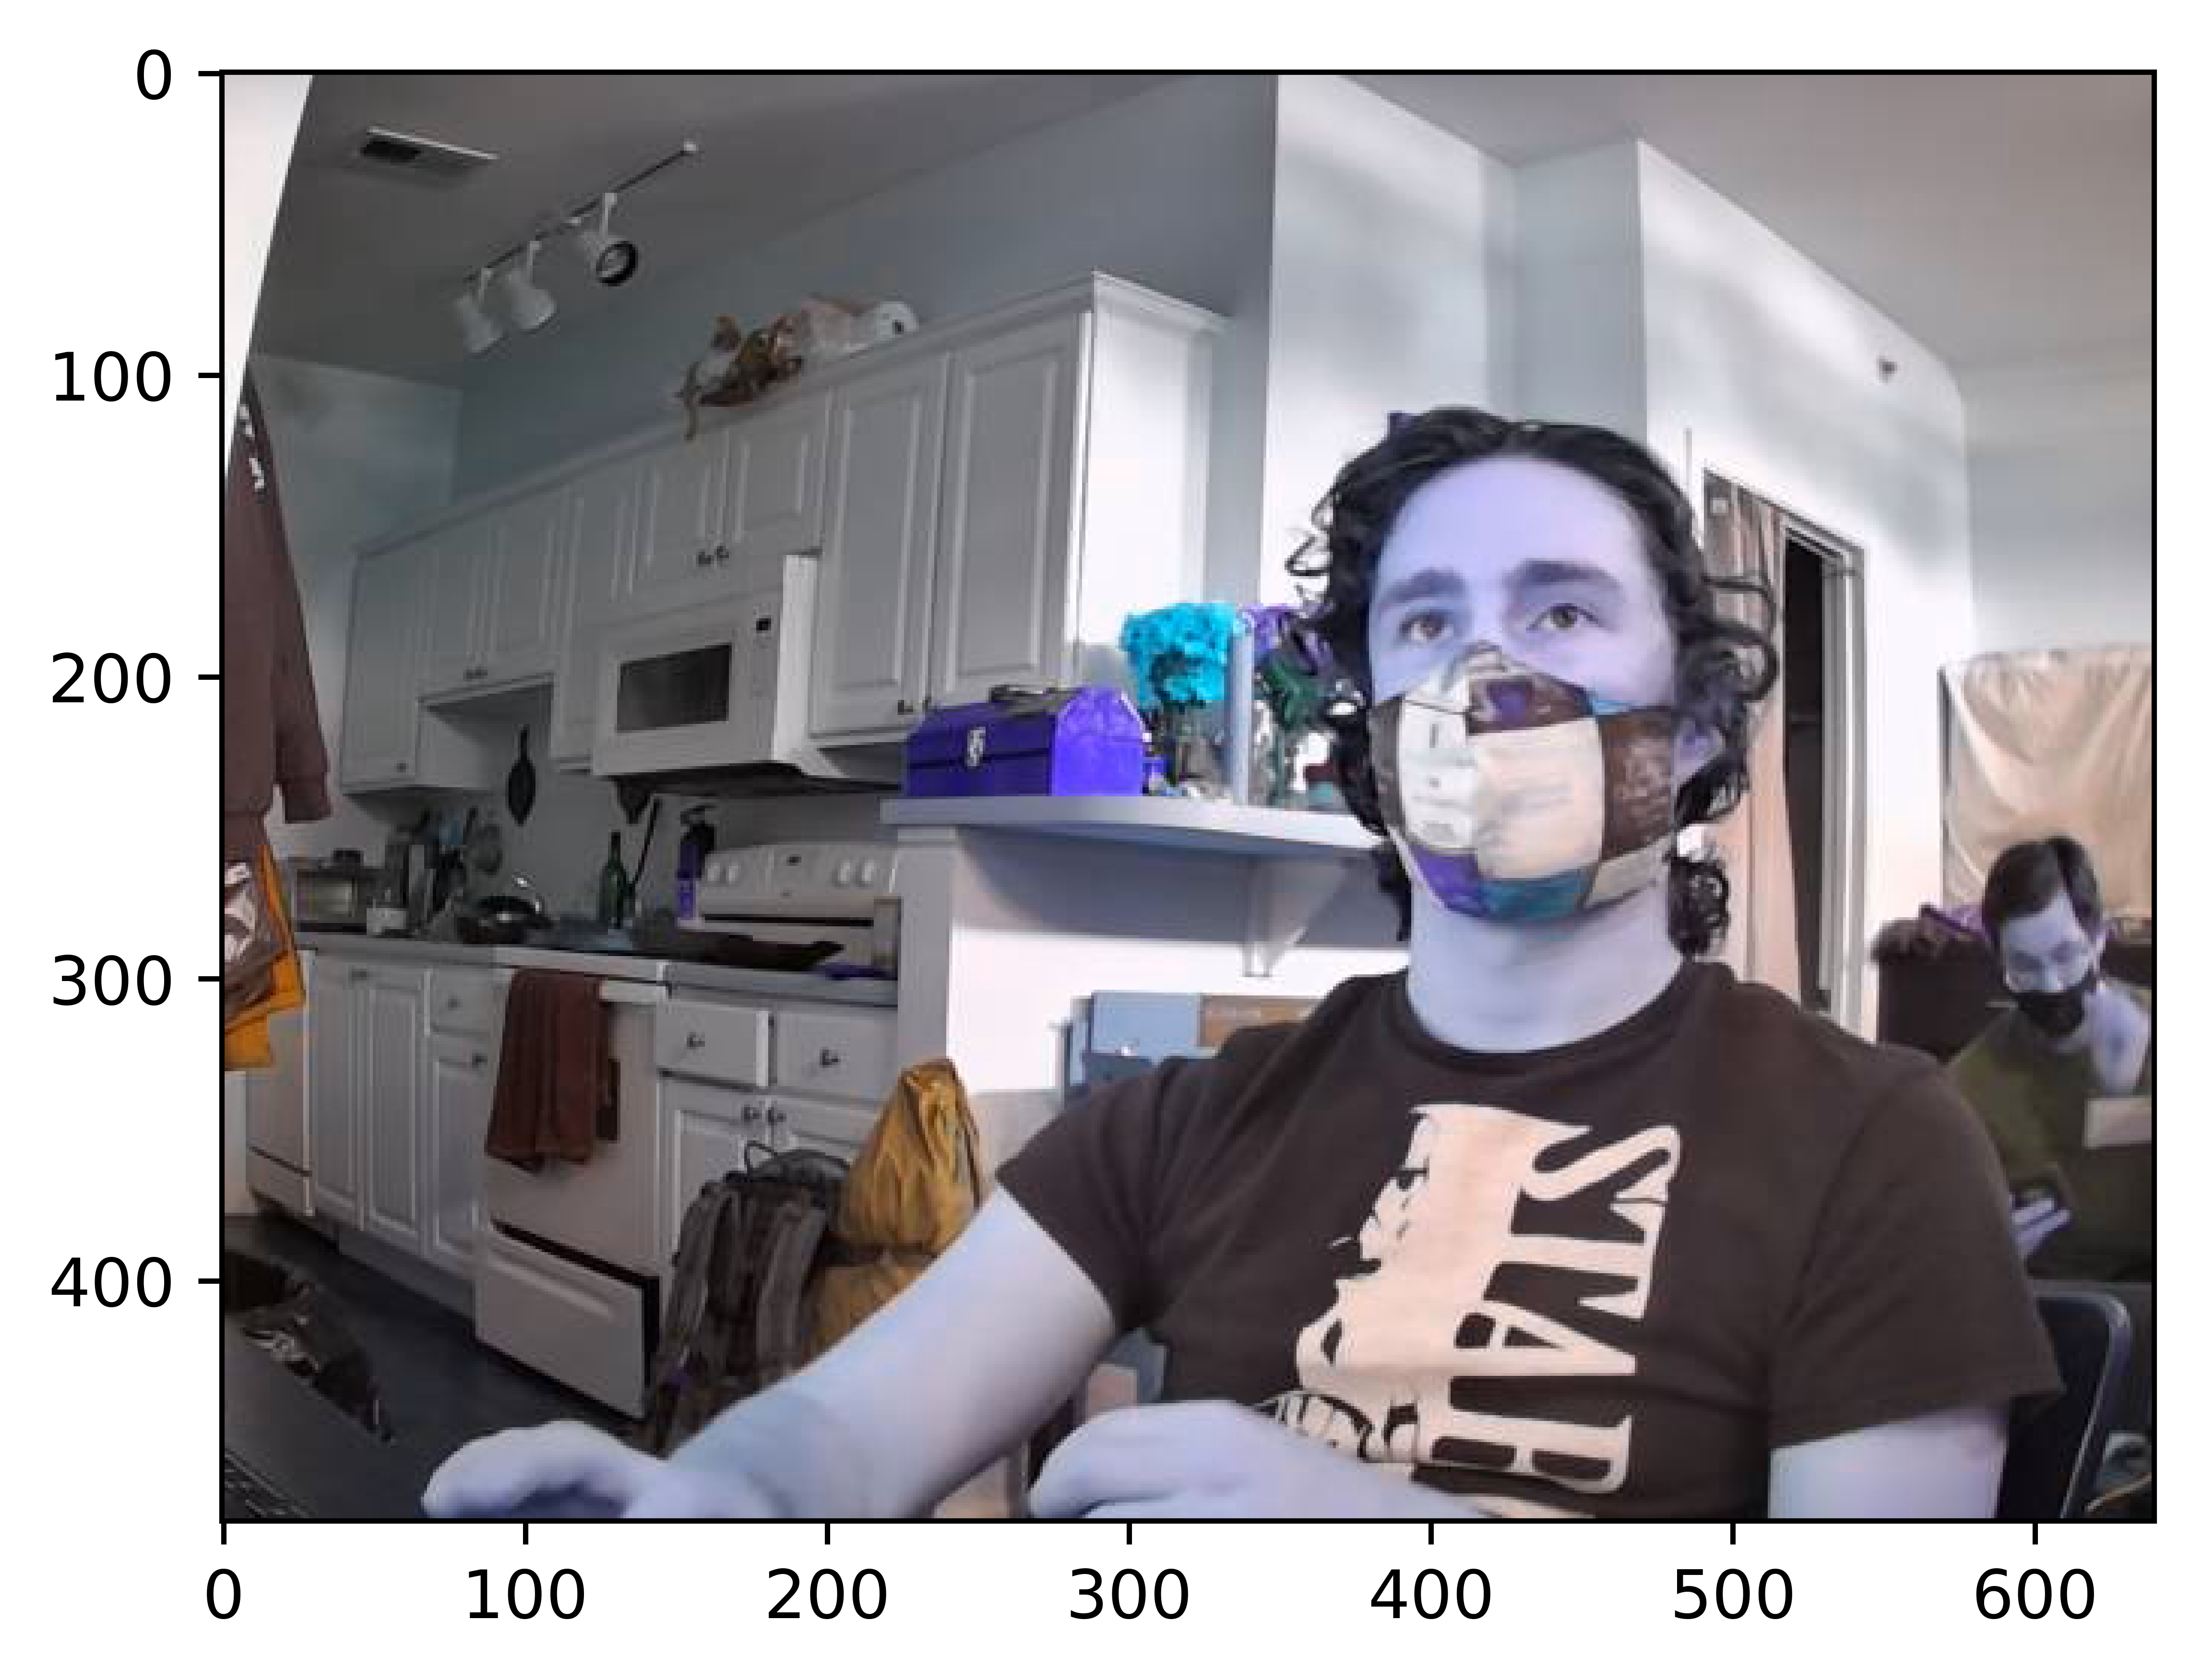

In [64]:
plt.imshow(im)

In [ ]:
masked_im = [0,0,0]

In [ ]:
for color_num in range(3):
    space_im = cv2.cvtColor(np.uint8(im), COLOR_SPACE)
    h_im = space_im[..., color_num]
    h_im_mask = np.reshape(np.abs((h_im - MODEL[color_num][0])/MODEL[color_num][1]) <= THRESHOLD[color_num],
                                  (im.shape[0], im.shape[1], 1))
    masked_im[color_num] = new_im * h_im_mask

In [ ]:
plt.imshow(masked_im[0])

In [ ]:
plt.imshow(masked_im[1])

In [ ]:
plt.imshow(masked_im[2])

In [ ]:
MODEL

In [ ]:
THRESHOLD